In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from read_data import ChestXrayDataSet
from sklearn.metrics import roc_auc_score
from model import DenseNet121
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="3,4" #change to GPUs available to you

In [3]:
from catalyst.dl.runner import SupervisedRunner

In [4]:
from torch.utils.data import DataLoader

In [5]:
N_CLASSES = 14
CLASS_NAMES = ['Atelectasis', 
               'Cardiomegaly', 
               'Effusion', 
               'Infiltration', 
               'Mass', 
               'Nodule', 
               'Pneumonia',
               'Pneumothorax', 
               'Consolidation', 
               'Edema', 
               'Emphysema', 
               'Fibrosis', 
               'Pleural_Thickening', 
               'Hernia']
DATA_DIR = '/raid/urinbayev/Chest_images/overall'
TEST_IMAGE_LIST = 'labels/test_list.txt'
BATCH_SIZE = 8

In [6]:
cudnn.benchmark = True

# initialize and load the model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DenseNet121(N_CLASSES).to(device)




# Add the path to the model you want to check
checkpoint = torch.load('./logs/20_epochs_densenet121_RAdam_weights8_loss_2_GPUs/checkpoints/best.pth')
remove_data_parallel = False # Change if you don't want to use nn.DataParallel(model)


model.load_state_dict(checkpoint['model_state_dict'])




normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])

test_dataset = ChestXrayDataSet(data_dir=DATA_DIR,
                                image_list_file=TEST_IMAGE_LIST,
                                transform=transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.TenCrop(224),
                                    transforms.Lambda
                                    (lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                    transforms.Lambda
                                    (lambda crops: torch.stack([normalize(crop) for crop in crops]))
                                ]))
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=8, pin_memory=True)



In [7]:
# initialize the ground truth and output tensor
gt = torch.FloatTensor()
gt = gt.cuda()
pred = torch.FloatTensor()
pred = pred.cuda()

# switch to evaluate mode
model.eval()
with torch.no_grad():
    for i, (inp, target) in enumerate(test_loader):
        target = target.cuda()
        gt = torch.cat((gt, target), 0)
        bs, n_crops, c, h, w = inp.size()
        input_var = torch.autograd.Variable(inp.view(-1, c, h, w).cuda())
        output = model(input_var)
        output_mean = output.view(bs, n_crops, -1).mean(1)
        pred = torch.cat((pred, output_mean.data), 0)

In [8]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [9]:
gt_np = gt.cpu().numpy()
pred_np = sigmoid(pred.cpu().numpy())

In [10]:
gt_np

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:
pred_np

array([[0.26873958, 0.3538213 , 0.0738459 , ..., 0.01129663, 0.10315987,
        0.00331728],
       [0.06302556, 0.01165818, 0.01777738, ..., 0.05903173, 0.13342196,
        0.00397454],
       [0.10087709, 0.01080159, 0.02763823, ..., 0.00760946, 0.08731418,
        0.00242156],
       ...,
       [0.9280886 , 0.26580453, 0.83948326, ..., 0.14060335, 0.2990595 ,
        0.00621074],
       [0.8940775 , 0.26700604, 0.8836089 , ..., 0.10606526, 0.31732586,
        0.00539979],
       [0.8864307 , 0.22073017, 0.9382485 , ..., 0.05365188, 0.78084326,
        0.00217422]], dtype=float32)

In [12]:
Y_t = [] #labels for each anomaly
for i in range(14):
    Y_t.append([])
    for x in gt_np:
        Y_t[i].append(x[i])

In [13]:
Y_pred = [] #preds for each anomaly
for j in range(14):
    Y_pred.append([])
    for y in pred_np:
        Y_pred[j].append(y[j])

In [14]:
from sklearn.metrics import roc_auc_score

In [15]:
AUCs = [] # AUCs for each 
for i in range(14):
    auc = roc_auc_score(Y_t[i], Y_pred[i])
    AUCs.append(auc)

In [16]:
AUCs

[0.8089186656772271,
 0.9128154113433986,
 0.8782000306074442,
 0.7046557406219764,
 0.8370621640996316,
 0.7735656822468928,
 0.753566426117952,
 0.8750701913161878,
 0.8072588087929993,
 0.8932593196147899,
 0.9340085001625548,
 0.8290390555242235,
 0.7856840048254965,
 0.9598238875738765]

In [17]:
import statistics 

In [18]:
statistics.mean(AUCs)

0.8394948491803322

In [19]:
from sklearn.metrics import accuracy_score
Acc = [] # AUCs for each 
for i in range(14):
    acc = accuracy_score(Y_t[i], np.around(Y_pred[i]))
    Acc.append(acc)
Acc

[0.7246021486203361,
 0.7690010252752641,
 0.6670084250880399,
 0.5228012303303169,
 0.6770382918022556,
 0.4660990505059511,
 0.5330985601569117,
 0.7009316631747872,
 0.6656711095261445,
 0.7682432131235234,
 0.8393884010163598,
 0.6773949092854277,
 0.5764275843623233,
 0.9843979851112201]

In [20]:
statistics.mean(Acc)

0.6837216855270616

In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
matrices=[] #for each
for i in range(14):
    matrix = confusion_matrix(Y_t[i], np.asarray(Y_pred[i])>0.6)
    matrices.append(matrix)

In [23]:
matrices[5]

array([[12264,  8834],
       [  289,  1046]])

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [25]:
def print_confusion_matrix(confusion_matrix, class_names = None, title = None ,figsize = (3,3), fontsize=20):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,)
   

    heatmap = sns.heatmap(df_cm, annot=True, fmt="d").set_title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
label_names = [
            'Atelectasis',
            'Cardiomegaly',
            'Effusion',
            'Infiltration',
            'Mass',
            'Nodule',
            'Pneumonia',
            'Pneumothorax',
            'Consolidation',
            'Edema',
            'Emphysema',
            'Fibrosis',
            'Pleural Thickening',
            'Hernia']

In [27]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

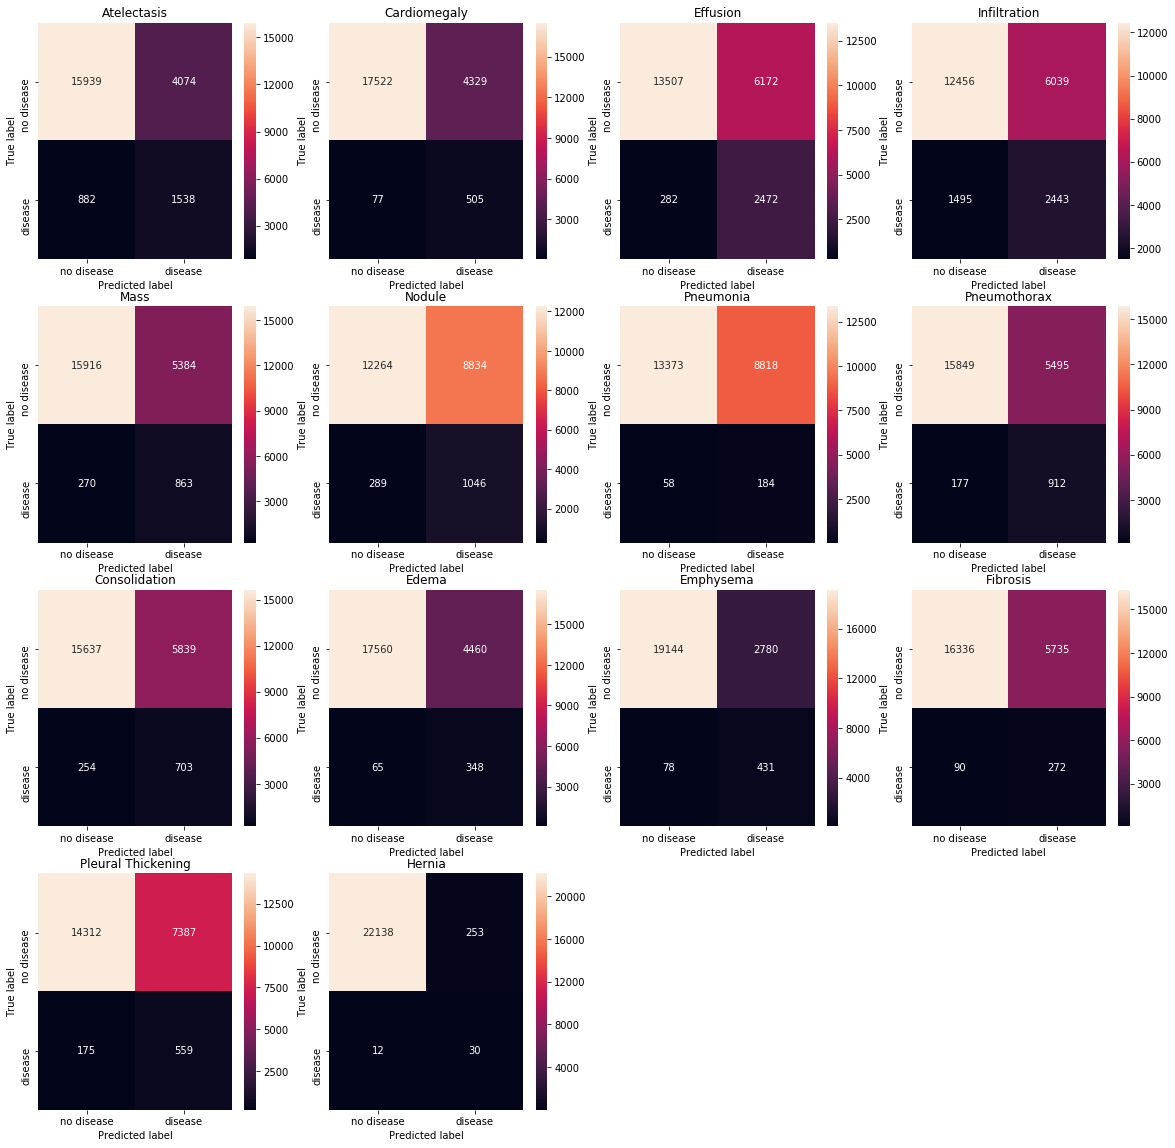

In [28]:
class_names = ['no disease', 'disease']
fig = plt.figure(figsize = (20,20))
for i in range(14):
    plt.subplot(4,4,i+1)
    
    df_cm = pd.DataFrame(
        matrices[i], index=class_names, columns=class_names,)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d").set_title(label_names[i])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
    
plt.show()

In [29]:
import sklearn.metrics as metrics

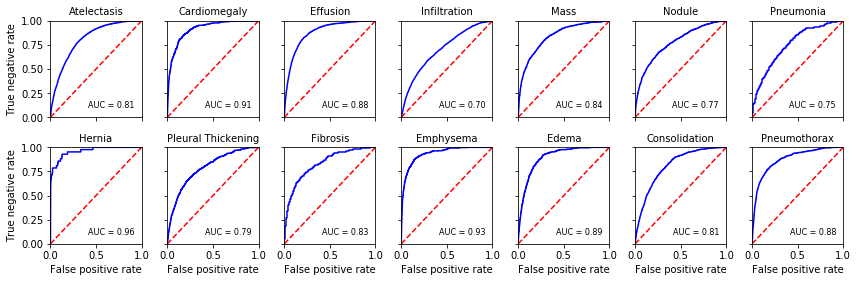

In [31]:
fig, axes2d = plt.subplots(nrows=2, ncols=7,
                           sharex=True, sharey=True,figsize = (12, 4))



for i, row in enumerate(axes2d):
    for j, cell in enumerate(row):
        if i==0:
            x=i+j
        else:
            x=13-i*j
        
        
        
        
        fpr, tpr, threshold = metrics.roc_curve(Y_t[x], Y_pred[x])
        roc_auc = metrics.auc(fpr, tpr)
        
        
        cell.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

        cell.legend(loc = 'lower right', handlelength=0,handletextpad=0,frameon=False, prop={'size': 8})

        cell.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        cell.set_title(label_names[x],fontsize=10)
        
        if i == len(axes2d) - 1:
            cell.set_xlabel('False positive rate')
        if j == 0:
            cell.set_ylabel('True negative rate')
fig.tight_layout(pad=1.0)    
plt.show()
